<a href="https://colab.research.google.com/github/ChGol/notebooks-workplace/blob/main/sklearn_diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training and test datasets comparision using toy dataset from sklearn: https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset

In [2]:
# Requirements versions limitation due to the Colab Python default version (3.7)
# Older version of Scipy due to the conflicts with imgaug dependency
!pip install scikit-learn==1.0.2 seaborn==0.11.2 pandas==1.3.5 numpy==1.21.6 scipy==1.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import ks_2samp
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [8]:
# Create train and test set
dataset = load_diabetes(as_frame=True)
X, y = dataset['data'], dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

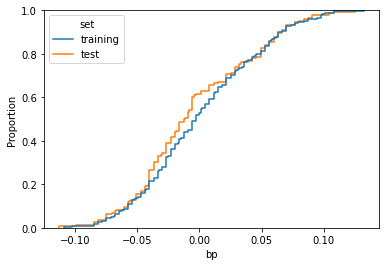

In [10]:
# Plot the cumulative distribution function of ‘bp’ feature for both training and test datasets
# bp stands for average blood pressure
feature_name = 'bp'
df = pd.DataFrame({
    feature_name: np.concatenate((X_train.loc[:, feature_name], X_test.loc[:, feature_name])),
    'set': ['training'] * X_train.shape[0] + ['test'] * X_test.shape[0]
})
sns.ecdfplot(data=df, x=feature_name, hue='set')

The two curves are similar, but there is a visible difference. 
The distribution of the feature has been distorted during sampling procedure. 
To quantify the difference between the two distributions with a single number, 
we can use Kolmogorov-Smirnov distance: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html

Given C(x) the cumulative distribution of feature x in the training dataset and 
G(x) the cumulative distribution of the same feature in the test dataset, 
the distance is defined as the maximum distance between these curves.

The lower the distance, the more similar the distributions of the features among the training and test datasets.

In [14]:
# Calculate distances for all features
distances = list(map(lambda i: ks_2samp(X_train.iloc[:, i], X_test.iloc[:, i]).statistic, range(X_train.shape[1])))
for i_ in range(X_train.shape[1]):
    print(X_train.columns[i_], distances[i_])


age 0.05715475749722325
sex 0.054979637171417996
bmi 0.08015549796371714
bp 0.11972417623102555
s1 0.07284339133654202
s2 0.08908737504627916
s3 0.07936875231395779
s4 0.06613291373565346
s5 0.05858941132913736
s6 0.09667715660866345


In [16]:
# Train linear model on current datasets using an R-squared score
linear_model_0 = LinearRegression()
linear_model_0.fit(X_train, y_train)
linear_model_score_0 = r2_score(y_test, linear_model_0.predict(X_test))
print(linear_model_score_0)

0.4033025232246107


In [19]:
# Loop through several values of the random state and
# calculate the distance , then select the random state that minimizes it
n_features = X.shape[1]
n_tries = 100
result = []
for random_state in range(n_tries):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
    distances = list(map(lambda i: ks_2samp(X_train.iloc[:, i], X_test.iloc[:, i]).statistic, range(n_features)))
    result.append((random_state, max(distances)))

result.sort(key=lambda x: x[1])
print(result[:10])

[(9, 0.07932452490449425), (52, 0.08324208579701681), (66, 0.08730564274764581), (55, 0.08779229627466725), (7, 0.0883519478307419), (61, 0.08942258559018906), (83, 0.08949558361924229), (51, 0.09039589264423194), (98, 0.09209917998880697), (3, 0.09504343382728667)]


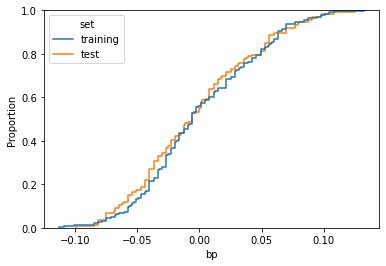

In [21]:
# Plot the cumulative distribution function of ‘bp’ feature for the best random state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=result[0][0])
df = pd.DataFrame({
    feature_name: np.concatenate((X_train.loc[:, feature_name], X_test.loc[:, feature_name])),
    'set': ['training'] * X_train.shape[0] + ['test'] * X_test.shape[0]
})
sns.ecdfplot(data=df, x=feature_name, hue='set')

In [23]:
# Check the distance for 'bp' feature using new sets
print(ks_2samp(X_train.loc[:, feature_name], X_test.loc[:, feature_name]).statistic)

0.07849721390855781


In [24]:
# Train again Linear model on the improved datasets
linear_model_1 = LinearRegression()
linear_model_1.fit(X_train, y_train)
linear_model_score_1 = r2_score(y_test, linear_model_1.predict(X_test))
print(linear_model_score_1)

0.5900352656383732
